## BLU06 - Learning Notebook - Part 2 of 3 - Time Series Pre-processing and Feature Engineering

In [1]:
import pandas as pd 
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt 
from sklearn.ensemble import GradientBoostingRegressor
from joblib import Parallel, delayed
from sklearn.metrics import mean_absolute_error
%matplotlib inline 
import numpy as np
plt.rcParams['figure.figsize'] = (16, 4)
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings(action="ignore")
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

from utils import * # We've added all the functions from the last BLU to the utils.py 

In the previous notebook we learned how to formulate time series multi-step forecasting as a regression problem where any ML model can be applied. But the airlines dataset is quite different from the ones you'll find in the wild. In this notebook we'll exlore a dataset that contains the customers that a store had with daily frequency. We'll learn about data pre-processing, feature engineering and play with gradient boosting and compare it with linear regression.

In [2]:
store = get_store_data()
store['date'] = pd.to_datetime(store['date'], format='%Y-%m-%d')
store = store.set_index('date')
store = store.sort_index()

# Data Pre-processing

Whenever analysing time series data it's always important to verify if it has all the timestamps. Let's look at our data:

In [3]:
store.head()

,customers
date,
2013-01-02,2111
2013-01-03,1833
2013-01-04,1863
2013-01-05,1509
2013-01-06,520


In [4]:
store.isnull().sum()

customers    0
dtype: int64

It seems to have daily frequency. To make sure we have no missing days we can resample the data to a daily frequency. This will add all possibly non-existing days as NaNs.

In [5]:
store_resampled = store.resample('D').mean()

In [6]:
store_resampled.isnull().sum()

customers    11
dtype: int64

Ok! So there were 11 missing days. Let's check which days where these:

In [7]:
store_resampled[store_resampled.isnull()['customers']]

,customers
date,
2013-12-25,NaN
2014-01-01,NaN
2014-12-25,NaN
2015-01-01,NaN
2015-07-07,NaN
2015-12-25,NaN
2016-01-01,NaN
2016-01-02,NaN
2016-01-03,NaN


Interesting! During Christmas and New Year the store should be closed, hence why there was no entry for the number of customers. Since we have no extra information regarding the other days we'll assume the store was also closed. So we have to replace this NaNs be 0s.

In [8]:
store_cleaned = store_resampled.fillna(0)

In [9]:
store_cleaned.isnull().sum()

customers    0
dtype: int64

# Feature Engineering

In the last BLU we used the simplest feature to predict time series: lags. But there's a lot more you can do! First let's see what a model with lags similar to the one we were using before can do.

In [10]:
split_date = '2017-6'
train = store_cleaned.loc[store_cleaned.index < split_date]
test = store_cleaned.loc[store_cleaned.index >= split_date]

In [11]:
predictions = predict_n_periods(series_=train, 
                  n_periods=len(test), 
                  model=LinearRegression(), 
                  num_periods_lagged=30,
                  target="customers"
                  )

  0%|          | 0/76 [00:00<?, ?it/s]

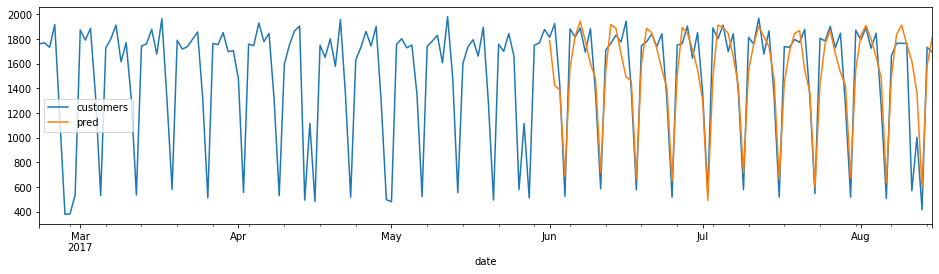

In [12]:
store[1500:].plot(label="original data")
pd.Series(predictions, index=test.index).plot(label="pred")
plt.legend();

In [13]:
mean_absolute_error(test,predictions)

154.90308385316638

### Lags and Diffs

Similar to lags, we can also use diffs of the time series to predict it. It's possible that knowing if the sales are increasing or decreasing can help predict better the next step. We can add this feature by simply doing:

In [14]:
store_features = store_cleaned.copy()

In [15]:
store_features['diff'] = store_cleaned.diff()

In [16]:
store_cleaned.head()

,customers
date,
2013-01-02,2111.0
2013-01-03,1833.0
2013-01-04,1863.0
2013-01-05,1509.0
2013-01-06,520.0


In [17]:
store_features.head()

,customers,diff
date,,
2013-01-02,2111.0,NaN
2013-01-03,1833.0,-278.0
2013-01-04,1863.0,30.0
2013-01-05,1509.0,-354.0
2013-01-06,520.0,-989.0


### Rolling Window features

Another type of feature that may be relevant are rolling window features. As you may recall, a rolling window refers to a window of days before the current step. We can extract features from that window such as the minimum, mean, maximum and standard deviation. To give information to the model about the recent statistical properties of the time series. 

In [18]:
store_features['rolling_max'] = store_features['customers'].rolling('7D').max()
store_features['rolling_min'] = store_features['customers'].rolling('7D').min()
store_features['rolling_mean'] = store_features['customers'].rolling('7D').mean()
store_features['rolling_std'] = store_features['customers'].rolling('7D').std()

### Datetime features

Datetime features refer to those you can extract simply from the timestamp. For example, giving information regarding which day of the week it is, which month, etc. can go a long way to help the model understand the time series better. For example, in our case we already know that the store is closed in Christmas and the New Year so we can one-hot encode those as a feature to the model.

In [19]:
holidays = store_features[((store_features.index.month==12) & (store_features.index.day==25))
              |((store_features.index.month==1) & (store_features.index.day==1))].customers

In [20]:
store_features['holidays'] = holidays + 1

In [21]:
store_features['holidays'] = store_features['holidays'].fillna(0)

Now let's add the day of the week and month features:

In [22]:
store_features['day_of_week'] = store_features.index.weekday
store_features['month'] = store_features.index.month

In [23]:
store_features.head(10)

,customers,diff,rolling_max,rolling_min,rolling_mean,rolling_std,holidays,day_of_week,month
date,,,,,,,,,
2013-01-02,2111.0,NaN,2111.0,2111.0,2111.000000,NaN,0.0,2,1
2013-01-03,1833.0,-278.0,2111.0,1833.0,1972.000000,196.575685,0.0,3,1
2013-01-04,1863.0,30.0,2111.0,1833.0,1935.666667,152.582218,0.0,4,1
2013-01-05,1509.0,-354.0,2111.0,1509.0,1829.000000,247.046554,0.0,5,1
2013-01-06,520.0,-989.0,2111.0,520.0,1567.200000,623.273776,0.0,6,1
2013-01-07,1807.0,1287.0,2111.0,520.0,1607.166667,566.003681,0.0,0,1
2013-01-08,1869.0,62.0,2111.0,520.0,1644.571429,526.080430,0.0,1,1
2013-01-09,1910.0,41.0,1910.0,520.0,1615.857143,501.279838,0.0,2,1
2013-01-10,1679.0,-231.0,1910.0,520.0,1593.857143,493.480303,0.0,3,1


So, regarding day of week you can check pandas [documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.dayofweek.html) on what each number means. Basically, Monday is 0 and Sunday is 6. But this brings a good point, is Monday closer to Sunday than to Thursday? "Of course it is closer, what kind of question is that?!" Well, the issue is that the current mapping between day of the week and number is the following:

- Monday: 0
- Thursday: 3
- Sunday: 6

This means that the distance between Monday and Thursday is smaller than Monday and Sunday, which gives wrong intuition to the model. This is particularly important for linear models, as well as kNNm K-means and neural networks. This means that we have to encode these features in a such a way that they convey their cyclical nature to the model.

### Circular Encoding

So how can we encode these features while mantaining their cyclical nature? We can use circular encoding. Basically, the idea is to encode these features using the sine and the cosine. For more information on this, check the optional notebook of this BLU. In practice this is how you add them:

In [24]:
store_features['sin_weekday'] = np.sin(2*np.pi*store_features.index.weekday/7)
store_features['cos_weekday'] = np.cos(2*np.pi*store_features.index.weekday/7)
        
store_features['sin_month'] = np.sin(2*np.pi*store_features.index.month/12)
store_features['cos_month'] = np.cos(2*np.pi*store_features.index.month/12)

Now let's drop the previous datetime features that were not encoded

In [25]:
store_features = store_features.drop(['day_of_week','month'], axis=1)

So our dataframe has a couple more features now:

In [26]:
store_features.head()

,customers,diff,rolling_max,rolling_min,rolling_mean,rolling_std,holidays,sin_weekday,cos_weekday,sin_month,cos_month
date,,,,,,,,,,,
2013-01-02,2111.0,NaN,2111.0,2111.0,2111.000000,NaN,0.0,0.974928,0.974928,0.5,0.5
2013-01-03,1833.0,-278.0,2111.0,1833.0,1972.000000,196.575685,0.0,0.433884,0.433884,0.5,0.5
2013-01-04,1863.0,30.0,2111.0,1833.0,1935.666667,152.582218,0.0,-0.433884,-0.433884,0.5,0.5
2013-01-05,1509.0,-354.0,2111.0,1509.0,1829.000000,247.046554,0.0,-0.974928,-0.974928,0.5,0.5
2013-01-06,520.0,-989.0,2111.0,520.0,1567.200000,623.273776,0.0,-0.781831,-0.781831,0.5,0.5


So let's see if any of these actually improve our model, but we have to test all these models in a validation set.

Note: With domain knowledge you can add even more features, such as: is it an holiday? is there a special Event? Even the weather! Feature engineering has a lot to do with creativity and thinking outside of the box. 

# Validation

To test which features actually improve model performance we'll add them to the _build_some_features_ function that we started creating on the last BLU:

In [27]:
def build_some_features(df_, num_periods_lagged=1, num_periods_diffed=0, weekday=False, month=False, rolling=[], holidays=False): 
    """
    Builds some features by calculating differences between periods  
    """
    # make a copy 
    df_ = df_.copy()
        
    # for a few values, get the lags  
    for i in range(1, num_periods_lagged+1):
        # make a new feature, with the lags in the observed values column
        df_['lagged_%s' % str(i)] = df_['customers'].shift(i)
        
    # for a few values, get the diffs  
    for i in range(1, num_periods_diffed+1):
        # make a new feature, with the diffs in the observed values column
        df_['diff_%s' % str(i)] = df_['customers'].diff(i)
    
    for stat in rolling:
        df_['rolling_%s'%str(stat)] = df_['customers'].rolling('7D').aggregate(stat)
        
    if weekday == True:
        df_['sin_weekday'] = np.sin(2*np.pi*df_.index.weekday/7)
        df_['cos_weekday'] = np.cos(2*np.pi*df_.index.weekday/7)
        
    if month == True:
        df_['sin_month'] = np.sin(2*np.pi*df_.index.month/12)
        df_['cos_month'] = np.cos(2*np.pi*df_.index.month/12)
        
    if holidays == True:
        holidays = df_[((df_.index.month==12) & (df_.index.day==25)) |((df_.index.month==1) & (df_.index.day==1))].customers
        df_['holidays'] = holidays + 1
        df_['holidays'] = df_['holidays'].fillna(0)
    
    return df_

Now let's create a parameter grid with the combinations we want to test using sklearn's [ParameterGrid](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html). The more combinations the more time it will take to run, so we'll just assume that the rolling statistics and the holidays improve the model. But feel free to add more options to the parameter grid and see if it improves the performance on the validation set.

Note that we're also adding the gradient boosting regressor model, to see if it obtains better results than the vanilla linear regression.

In [28]:
from sklearn.model_selection import ParameterGrid
param_grid = {'model': [LinearRegression(), GradientBoostingRegressor()], 
              'num_periods_lagged':np.arange(1,3),
              'num_periods_diffed':np.arange(0,3),
              'weekday':[True,False],
              'month':[True,False],
              'holidays': [True],
              'rolling' : [[np.mean,np.min,np.max,np.std]]
             }

grid = ParameterGrid(param_grid)

Now we can test on a validation set to see which combination of features gives best performance!

In [29]:
val_split_date = '2017-3'
test_split_date = '2017-6'
train = store_cleaned.loc[store_cleaned.index < val_split_date]
val = store_cleaned.loc[(val_split_date <= store_cleaned.index) & (store_cleaned.index < test_split_date)]
test = store_cleaned.loc[store_cleaned.index >= test_split_date]

The commented cell below implements the for loop that runs through the grid we created and finds the parameter group that minimizes the MAE in the validation set. It is commented because it takes some time. The other cell makes use of the Joblib library to parallelize the code and is considerably faster. In this laptop it takes about 3 minutes.

In [30]:
#error_lst = []

#for params in tqdm(grid):
#    predictions = predict_n_periods(series_=train, 
#                      n_periods=30, 
#                      model=params['model'], 
#                      num_periods_lagged=params['num_periods_lagged'],
#                      num_periods_diffed=params['num_periods_diffed'],
#                      weekday=params['weekday'],
#                      month=params['month'],
#                      rolling=[np.mean,np.max,np.min]
#                    )
#
#    error_lst.append(mean_absolute_error(val,predictions))
# pd.Series(error_lst).idxmin()

In [31]:
%%time 
# This is another cell that will take a long time to run. 

def wrap_model_selection(params): 
    predictions = predict_n_periods(series_=train, 
                      n_periods=len(val), 
                      model=params['model'], 
                      num_periods_lagged=params['num_periods_lagged'],
                      num_periods_diffed=params['num_periods_diffed'],
                      weekday=params['weekday'],
                      month=params['month'],
                      rolling=[np.mean,np.max,np.min]
                    )
    return [params,mean_absolute_error(val,predictions)]

res = Parallel(n_jobs=-1)(delayed(wrap_model_selection)(params=params) 
                          for params in tqdm(grid))

  0%|          | 0/48 [00:00<?, ?it/s]

CPU times: user 465 ms, sys: 117 ms, total: 582 ms
Wall time: 1min 54s


In [32]:
df = pd.DataFrame(res, columns=['params','error'])
df.sort_values('error').head()

,params,error
42,"{'holidays': True, 'model': ([DecisionTreeRegr...",120.003467
30,"{'holidays': True, 'model': ([DecisionTreeRegr...",120.880250
38,"{'holidays': True, 'model': ([DecisionTreeRegr...",122.396260
26,"{'holidays': True, 'model': ([DecisionTreeRegr...",124.900282
24,"{'holidays': True, 'model': ([DecisionTreeRegr...",125.576495


Let's inspect our best model a bit better:

In [33]:
df.sort_values('error').iloc[0][0]

{'holidays': True,
 'model': GradientBoostingRegressor(),
 'month': False,
 'num_periods_diffed': 1,
 'num_periods_lagged': 2,
 'rolling': [<function numpy.mean(a, axis=None, dtype=None, out=None, keepdims=<no value>, *, where=<no value>)>,
  <function numpy.amin(a, axis=None, out=None, keepdims=<no value>, initial=<no value>, where=<no value>)>,
  <function numpy.amax(a, axis=None, out=None, keepdims=<no value>, initial=<no value>, where=<no value>)>,
  <function numpy.std(a, axis=None, dtype=None, out=None, ddof=0, keepdims=<no value>, *, where=<no value>)>],
 'weekday': True}

It seems like the diffed feature and the month didn't really help. On the other hand the weekday feature and the gradient boosting regressor improved the performance.

# Testing

Now we can finally test on the test set with the best parameters and see if it improved since our dataset without feature engineering. But first we need to append the validation set to the training set

In [34]:
train = train.append(val)

In [35]:
predictions = predict_n_periods(series_=train, 
                  n_periods=len(test), 
                  model=GradientBoostingRegressor(), 
                  num_periods_lagged=2,
                  num_periods_diffed=0,
                  weekday=True,
                  month=False,
                  rolling=[np.mean,np.min,np.max,np.std],
                  holidays=True,
                  target="customers"
                  )

  0%|          | 0/76 [00:00<?, ?it/s]

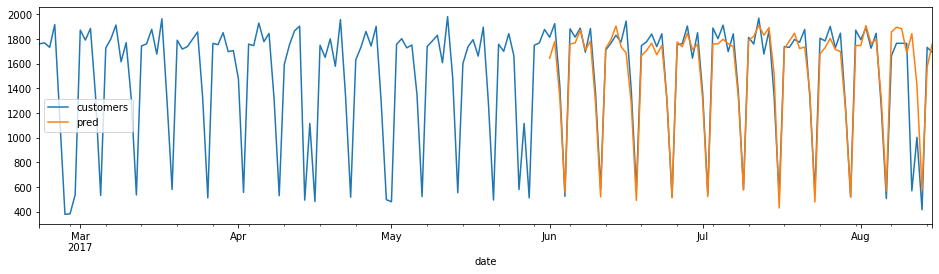

In [36]:
store[1500:].plot(label="original data")
pd.Series(predictions, index=test.index).plot(label="pred")
plt.legend();

In [37]:
mean_absolute_error(test,predictions)

95.13296770005648

Wow, that's a big improvement from the non-feature-engineered model. Feature engineering works!

But it's interesting that the MAE in the test set is lower than on the val set. This may go a bit against your expectations: Since we did the tunning on the val set we would expect it to perform better there. But that doens't happen. Remember when we talked about stationarity in the last BLU? Well, we'll talk about it in the next notebook.